In [1]:
# HIDDEN
using CSV
using DataFrames
using MLJ
using Statistics
using StatsPlots
Base.displaysize() = (5, 80)

## Cross-Validation

In the previous section, we observed that we needed a more accurate way of simulating the test error to manage the bias-variance trade off. To reiterate, training error is misleadingly low, because we are fitting our model on the training set. We need to choose a model without using the test set, so we split our training set again, into a validation set. Cross-validation provides a method of estimating our model error using a single observed dataset by separating data used for training from the data used for model selection and final accuracy. 

## Train-Validation-Test Split

One way to accomplish this is to split the original dataset into three disjoint subsets:

* Training set: The data used to fit the model.
* Validation set: The data used to select features.
* Test set: The data used to report the model's final accuracy.

After splitting, we select a set of features and a model based on the following procedure:

1. For each potential set of features, fit a model using the training set. The error of a model on the training set is its *training error*.
1. Check the error of each model on the validation set: its *validation error*. Select the model that achieves the lowest validation error. This is the final choice of features and model.
1. Calculate the *test error*, error of the final model on the test set. This is the final reported accuracy of the model. We are forbidden from adjusting the features or model to decrease test error; doing so effectively converts the test set into a validation set. Instead, we must collect a new test set after making further changes to the features or the model.

This process allows us to more accurately determine the model to use than using the training error alone. By using cross-validation, we can test our model on data that it wasn't fit on, simulating test error without using the test set. This gives us a sense of how our model performs on unseen data.  

**Size of the train-validation-test split**

The train-validation-test split commonly uses 70% of the data as the training set, 15% as the validation set, and the remaining 15% as the test set. Increasing the size of the training set helps model accuracy but causes more variation in the validation and test error. This is because a smaller validation set and test set are less representative of the sample data.

## Training Error and Test Error

A model is of little use to us if it fails to generalize to unseen data from the population. The test error provides the most accurate representation of the model's performance on new data since we do not use the test set to train the model or select features.

In general, the training error decreases as we add complexity to our model with additional features or more complex prediction mechanisms. The test error, on the other hand, decreases up to a certain amount of complexity then increases again as the model overfits the training set. This is due the fact that at first, bias decreases more than variance increases. Eventually, the increase in variance surpasses the decrease in bias. 
![feature_train_test_error.png](https://raw.githubusercontent.com/DS-100/textbook/master/assets/feature_train_test_error.png)

## K-Fold Cross-Validation

The **train-validation-test split** method is a good method to simulate test error through the validation set. However, making the three splits results in too little data for training. Also, with this method the validation error may be prone to high variance because the evaluation of the error may depend heavily on which points end up in the training and validation sets.

To tackle this problem, we can run the train-validation split multiple times on the same dataset. The dataset is divided into *k* equally-sized subsets (*$k$ folds*), and the train-validation split is repeated *k* times. Each time, one of the *k* folds is used as the validation set, and the remaining *k-1* folds are used as the training set. We report the model's final validation error as the average of the $ k $ validation errors from each trial. This method is called **k-fold cross-validation**. 

The diagram below illustrates the technique when using five folds:

![feature_5_fold_cv.jpg](https://github.com/DS-100/textbook/blob/master/assets/feature_5_fold_cv.jpg?raw=true)

The biggest advantage of this method is that every data point is used for validation exactly once and for training *k-1* times. Typically, a *k* between 5 to 10 is used, but *k* remains an unfixed parameter. When *k* is small, the error estimate has a lower variance (many validation points) but has a higher bias (fewer training points). Vice versa, with large *k* the error estimate has lower bias but has higher variance. 

$k$-fold cross-validation takes more computation time than the train-validation split since we typically have to refit each model from scratch for each fold. However, it computes a more accurate validation error by averaging multiple errors together for each model.

The `MLDataUtils` library provides a convenient [`kfolds`](https://mldatautilsjl.readthedocs.io/en/latest/data/pattern.html#k-folds-repartitioning) function to implement $k$-fold cross-validation.

## Bias-Variance Tradeoff

Cross-validation helps us manage the bias-variance tradeoff more accurately. Intuitively, the validation error estimates test error by checking the model's performance on a dataset not used for training; this allows us to estimate both model bias and model variance. K-fold cross-validation also incorporates the fact that the noise in the test set only affects the noise term in the bias-variance decomposition whereas the noise in the training set affects both bias and model variance. To choose the final model to use, we select the one that has the lowest validation error.



## Example: Model Selection for Ice Cream Ratings
We will use the complete model selection process, including cross-validation, to select a model that predicts ice cream ratings from ice cream sweetness. The complete ice cream dataset and a scatter plot of the overall rating versus ice cream sweetness are shown below.

In [127]:
# HIDDEN
using LinearAlgebra
using Polynomials
using Printf
using Random

function poly_transformer(column, degree)
    poly_matrix = Matrix(I, degree+1, degree+1)
    poly_cols = []
    for row in eachrow(poly_matrix)
        p = Poly(row)
        append!(poly_cols, [p.(column)])
    end
    return poly_cols
end;

In [27]:
# HIDDEN
ice = CSV.read("icecream.csv")
X = DataFrame(poly_transformer(ice.sweetness, 2))
y = ice.overall

#lr_model = @load LinearRegressor pkg=ScikitLearn
lr = machine(lr_model, X, y)
fit!(lr, verbosity=0)
xs = DataFrame(poly_transformer(collect(range(3.5, 12.5, length=300)), 2))
rating_pred = predict(lr, xs)

temp = DataFrame(sweetness=xs.x2, overall=rating_pred)

Random.seed!(42)
x_devs = randn(nrows(temp))*0.2
y_devs = randn(nrows(temp))*0.2
temp.sweetness .= round.((temp.sweetness .+ x_devs), digits=2)
temp.overall .= round.((temp.overall .+ y_devs), digits=2)

ice = vcat(temp, ice);

In [28]:
ice

,sweetness,overall
,Float64,Float64
1,3.39,3.57
2,3.44,3.2
3,3.57,3.07
4,3.53,3.73
5,3.98,3.2
⋮,⋮,⋮


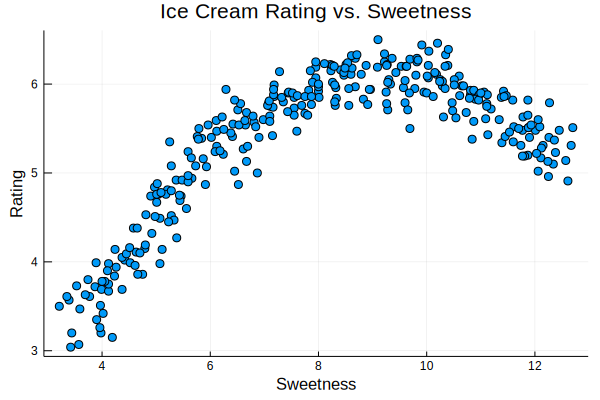

In [30]:
# HIDDEN
@df ice scatter(:sweetness, :overall, legend=false)
title!("Ice Cream Rating vs. Sweetness")
xlabel!("Sweetness")
ylabel!("Rating")

Using degree 10 polynomial features on 9 random points from the dataset result in a perfectly accurate model for those data points. Unfortunately, this model fails to generalize to previously unseen data from the population.

In [36]:
# HIDDEN

ice2 = CSV.read("icecream.csv")
X_ten = DataFrame(poly_transformer(ice2.sweetness, 10))
y = ice2.overall

lr_ten = machine(lr_model, X_ten, y)
fit!(lr_ten, verbosity=0)

Machine{LinearRegressor} @ 1…00


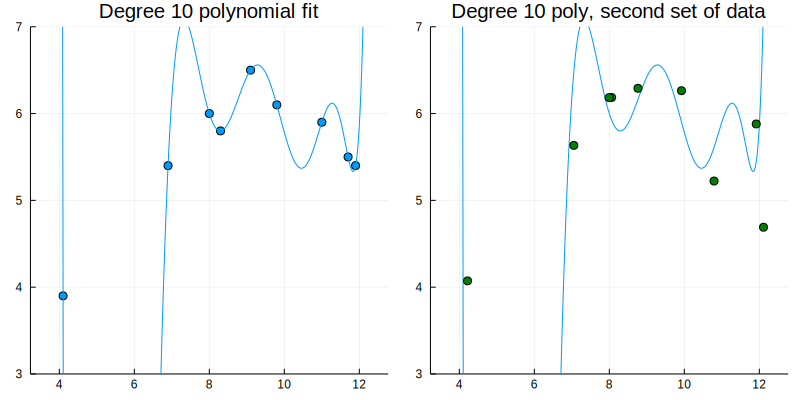

In [60]:
# HIDDEN
Random.seed!(1)
x_devs = randn(nrows(ice2))*0.4
y_devs = randn(nrows(ice2))*0.4

p1 = scatter(ice2.sweetness, ice2.overall, legend=false, ylim=(3, 7),
    title="Degree 10 polynomial fit", color=1)
points = collect(range(3.5, 12.5, length=1000))
xs = DataFrame(poly_transformer(points, 10))
ys = predict(lr_ten, xs)
plot!(xs.x2, ys, color=1)

p2 = plot(xs.x2, ys, legend=false, ylim=(3, 7),
    title="Degree 10 poly, second set of data")
scatter!([ice2.sweetness .+ x_devs], [ice2.overall .+ y_devs], color=:green)
plot(p1,p2, size=(800,400))

Instead of the above method, we first partition our data into training, validation, and test datasets using Julia's [`partition`](https://docs.julialang.org/en/v1/base/iterators/#Base.Iterators.partition) method to perform a 70/30% train-test split.

In [68]:
y, X = unpack(ice, ==(:overall), colname -> true)
train, test = partition(eachindex(y), 0.7, shuffle=true)

println("Training set size: ", length(train))
println("    Test set size: ", length(test))

Training set size: 216
    Test set size: 93


In [69]:
X

309-element Array{Float64,1}:
 ⋮

We now fit polynomial regression models using the training set, one for each polynomial degree from 1 to 10.

In [76]:
# First, we add polnomial features to X by using our function defined in section 14.2
X_polys = [DataFrame(poly_transformer(X, i)) for i in 1:10]

# Display the X_train with degree 5 polynomial features
X_polys[5][train, :]

,x1,x2,x3,x4,x5,x6
,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,5.66,32.0356,181.321,1026.28,5808.74
2,1.0,5.07,25.7049,130.324,660.742,3349.96
3,1.0,5.65,31.9225,180.362,1019.05,5757.61
4,1.0,6.98,48.7204,340.068,2373.68,16568.3
5,1.0,5.01,25.1001,125.752,630.015,3156.38
⋮,⋮,⋮,⋮,⋮,⋮,⋮


We will then perform 5-fold cross-validation on the 10 featurized datasets. To do so, we will define a function that:
1. Uses the [`MLDataUtils.kfolds`](https://mldatapatternjl.readthedocs.io/en/latest/documentation/folds.html#kfolds) function to get 5 splits on the training data. Note that we will use `kfolds` to obtain the indicies of the data for that split, but it can also be used to split a dataset.
2. For each split, select out the rows and columns based on the split indices and features.
3. Fit a linear model on the training split.
4. Compute the mean squared error on the validation split.
5. Return the average error across all cross validation splits.

In [113]:
using MLDataUtils

function mse_cost(y_pred, y_actual)
    return mean((y_pred .- y_actual) .^ 2)
end
    
function compute_CV_error(model, X, y, train)
    validation_errors = []
    kf_idx = kfolds(train, 5)

    for (train_idx, valid_idx) in kf_idx
        split_X_train = X[train_idx, :]
        split_X_valid = X[valid_idx, :]
        split_y_train = y[train_idx]
        split_y_valid = y[valid_idx]
        
        # Fit the model on the training split
        model_mac = machine(model, split_X_train, split_y_train)
        fit!(model_mac, verbosity=0)
        
        # Compute the MSE on the validation split
        y_hat = predict(model_mac, split_X_valid)
        error = mse_cost(y_hat, split_y_valid)
        append!(validation_errors, error)
    end
    
    # average validation errors
    return mean(validation_errors)
end;

In [120]:
# We train a linear regression classifier for each featurized dataset and perform cross-validation
# We set fit_intercept=false for our LinearRegressor since 
# our poly_transformer function adds the bias column for us.

lr_model = LinearRegressor(fit_intercept=false)
cross_validation_errors = [compute_CV_error(lr_model, X_poly, y, train) for X_poly in X_polys];

In [121]:
# HIDDEN
cv_df = DataFrame(Validation_Error=cross_validation_errors)
Base.displaysize() = (10, 80)
cv_df

,Validation_Error
,Float64
1,0.368309
2,0.0580954
3,0.0603626
4,0.0588656
5,0.059062
6,0.0554704
7,0.0553247
8,0.0557178
9,0.0562346


We can see that as we use higher degree polynomial features, the validation error decreases and increases again.

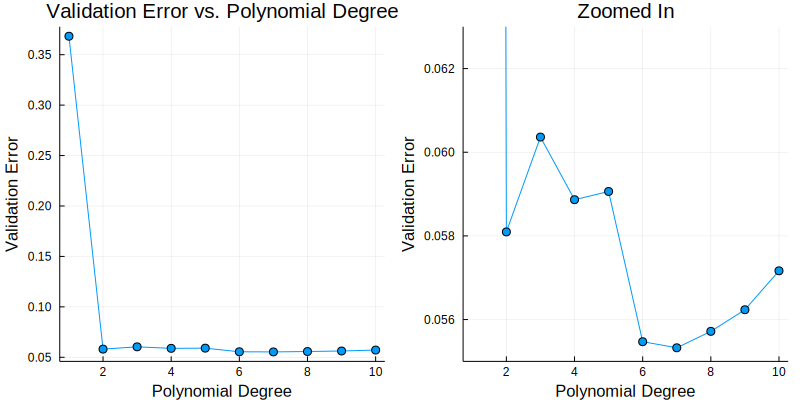

In [122]:
#HIDDEN
p1 = plot(cv_df.Validation_Error, legend=false, shape=:circle,
    title="Validation Error vs. Polynomial Degree",
    xlabel="Polynomial Degree", ylabel="Validation Error")

p2 = plot(cv_df.Validation_Error, legend=false, shape=:circle, ylim=(0.055, 0.063),
    title="Zoomed In",
    xlabel="Polynomial Degree", ylabel="Validation Error")

plot(p1,p2, size=(800,400))

Examining the validation errors reveals that the most accurate model used degree 7 polynomial features, but it was really similar to the degree 2 polynomial features model. Thus, we select the degree 2 polynomial model as our final model and fit it on the all of the training data at once. Then, we compute its error on the test set.

In [129]:
best_model = machine(lr_model, X_polys[2][train, :], y[train])
fit!(best_model, verbosity=0)

y_hat_train = predict(best_model, X_polys[2][train, :])
training_error = mse_cost(y_hat_train, y[train])

y_hat_test = predict(best_model, X_polys[2][test, :])
test_error = mse_cost(y_hat_test, y[test])

validation_error = cross_validation_errors[2]
println("Degree 2 polynomial")
@printf(" Training error: %0.5f\n", training_error)
@printf(" Validation error: %0.5f\n", validation_error)
@printf(" Test error: %0.5f\n", test_error)

Degree 2 polynomial
 Training error: 0.05677
 Validation error: 0.05810
 Test error: 0.04689


For future reference, [`MLJ.CV`](https://alan-turing-institute.github.io/MLJ.jl/stable/evaluating_model_performance/#MLJ.CV) can be used in conjunction with [`evaluate`](https://alan-turing-institute.github.io/MLJ.jl/stable/evaluating_model_performance/) to automatically perform cross-validation when evaluating model performance, so we don't have to break the data into training and validation sets ourselves.

Also, note that it is very common to have the test error higher than the validation error, which in turn would be higher than the training error. The training error would be the lowest because the model is fit on the training data. Fitting the model minimizes the mean squared error for that dataset. The validation error and the test error are usually higher than the training error because the error is computed on an unknown dataset that the model hasn't seen.

## Summary

We use the widely useful cross-validation technique to manage the bias-variance tradeoff. After computing a train-validation-test split on the original dataset, we use the following procedure to train and choose a model.

1. For each potential set of features, fit a model using the training set. The error of a model on the training set is its *training error*.
1. Check the error of each model on the validation set using $k$-fold cross-validation: its *validation error*. Select the model that achieves the lowest validation error. This is the final choice of features and model.
1. Calculate the *test error*, error of the final model on the test set. This is the final reported accuracy of the model. We are forbidden from adjusting the model to increase test error; doing so effectively converts the test set into a validation set. Instead, we must collect a new test set after making further changes to the model.